In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from model import Custom_Network
from datetime import datetime
from matplotlib import pyplot as plt

In [140]:
class Custom_Network(nn.Module):
    def __init__(self):
        #super() function makes class inheritance more manageable and extensible
        super(Custom_Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.max1 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(in_features=16 * 29 * 29, out_features=2048)
        self.fc2 = nn.Linear(in_features=2048, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        print(x.shape)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max1(x)
        print(x.shape)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.max1(x)
        print(x.shape)
        
        x = torch.flatten(x, 1)
        print(x.shape)

        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.relu(x)

        x = self.fc3(x)

        output = F.log_softmax(x, dim=1)
        return output

In [141]:
def train(model, device, train_loader, optimizer, epoch):
	model.train()
	for batch_idx, (data, target) in enumerate(train_loader):
		data, target = data.to(device), target.to(device)
		#data = data.reshape(data.size(0), -1)
		# print(data.shape, target.shape)
		optimizer.zero_grad()
		output = model(data)
		loss = F.nll_loss(output, target)
		loss.backward()
		optimizer.step()

		if batch_idx % 10 ==0:
			print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
				epoch, batch_idx * len(data), len(train_loader.dataset),
				100. * batch_idx / len(train_loader), loss.item()))


In [142]:
def test(model, device, test_loader):
	model.eval()
	test_loss = 0
	correct = 0
	# no_grad() prevents codes from tracking records or using memories 
	with torch.no_grad():
		for data, target in test_loader:
			data, target = data.to(device), target.to(device)
			data = data.reshape(data.size(0), -1)
			output = model(data)
			test_loss += F.nll_loss(output, target, reduction = 'sum').item()
			pred = output.argmax(dim = 1, keepdim = True) # get the index of the max log-probability
			correct += pred.eq(target.view_as(pred)).sum().item()
	test_loss/=len(test_loader.dataset)
	print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
		test_loss, correct, len(test_loader.dataset),
		100. * correct / len(test_loader.dataset)))

In [143]:
def save_models(model):
    print()
    torch.save(model.state_dict(), "models/trained.model")
    print("****----Checkpoint Saved----****")
    print()

In [144]:
def main():
    # parser = argparse.ArgumentParser(description = 'Deep Learning Framework 1 Argument')
    # parser.add_argument('--epochs', type = int, default = 100, metavar = 'N', help = 'number of epochs to train and test the model (default=100)')
    # args = parser.parse_args()
    #log()

    """
    follow instructions to create your own data loader 

    """
    input_dim = 128;
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(input_dim),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])
    test_transform = transforms.Compose([
        transforms.Resize(input_dim),
        transforms.CenterCrop(input_dim),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])
    
    train_dataset = datasets.ImageFolder("dataset/train", train_transform)
    test_dataset = datasets.ImageFolder("dataset/test", test_transform)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = Custom_Network().to(device)
    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    scheduler = StepLR(optimizer, step_size = 1, gamma = 0.8)

    # set you own epoch
    for epoch in range(1):

        """
        use train and test function to train and test your model
            
        """
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
    #save_models(model)


In [145]:
def log():
	# read file into string
	with open('model.py', 'r') as inputfile:
		textstr = inputfile.read()
		fn = "model"+datetime.now().strftime('%Y_%m_%d_%H_%M_%S') + ".txt"
		with open("logs/"+fn, 'w') as outputfile:
			outputfile.write(textstr)
	with open('torch_template.py', 'r') as inputfile:
		textstr = inputfile.read()
		fn = "main"+datetime.now().strftime('%Y-%m-%d %H-%M-%S') + ".txt"
		with open("logs/"+fn, 'w') as outputfile:
			outputfile.write(textstr)

In [95]:
input_dim = 128;
train_transform = transforms.Compose([
    transforms.Resize(input_dim),
        transforms.CenterCrop(input_dim),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),

])
test_transform = transforms.Compose([
    transforms.Resize(input_dim),
    transforms.CenterCrop(input_dim),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder("dataset/train", train_transform)
test_dataset = datasets.ImageFolder("dataset/test", test_transform)

In [96]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle=True)

In [97]:
train_loader.dataset.classes

['car', 'motorbike']

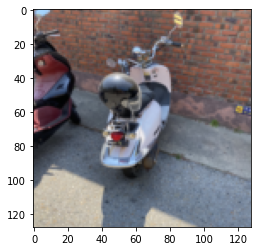

In [101]:
from torchvision.transforms import ToPILImage
to_img = ToPILImage()

for batch_idx, (data, target) in enumerate(test_loader):
    image = data[0,:]
    plt.imshow(to_img(image))
    break

In [81]:
main()

NameError: name 'main' is not defined